In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

#### 데이터 전처리

In [2]:
senior_df = pd.read_csv("노인실태조사.csv")
senior_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10097 entries, 0 to 10096
Columns: 915 entries, PID to s_wgt1
dtypes: float64(3), int64(829), object(83)
memory usage: 70.5+ MB


In [3]:
# df=senior_df[['RES_AGE', 'RES_MAR', 'S5_1', 'C10',
#               'E3', 'E4',
#               'J2']]
# df.columns = ['연령', '혼인상태', '동거인수', '장애여부',
#               '향후 근로 희망 여부', '노인일자리 경험여부',
#               '수급자 여부'
# df.info()
              
df=senior_df[['RES_AGE', 'D8']]
df.columns = ['연령', '종교']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10097 entries, 0 to 10096
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   연령      10097 non-null  int64
 1   종교      10097 non-null  int64
dtypes: int64(2)
memory usage: 157.9 KB


In [4]:
# 임금 고숙련 : 1
# 임금 중숙련 : 2
# 임금 저숙련 : 3
# 자영업 : 4
# 무급가족 종사자 : 5
# 은퇴 : 6
# 비경활 : 9

df['직업'] = np.where(senior_df['E1_1'].isin([11,12,13,14,15,21,22,23,24,25,26,27,28]),1,
                     np.where(senior_df['E1_1'].isin([31,32,33,39,61,62,63,72,73,74,75,76,77,78,79,81,82,83,84,85,86,87,88,89,100]),2,
                              np.where(senior_df['E1_1'].isin([41,42,43,44,51,52,53,91,92,93,94,95,99]),3,
                                       np.where(senior_df['E1_3'].isin([3,4]),4,
                                                np.where(senior_df['E1_3']==6 ,5,
                                                         np.where(senior_df['E1']==2, 6,
                                                                  np.where(senior_df['E1_1']==999,9,np.nan)))))))

In [5]:
df['직업'].value_counts()

6.0    4908
3.0    2447
9.0    1404
2.0     927
1.0     383
5.0       4
4.0       2
Name: 직업, dtype: int64

In [6]:
# 혼인상태
# 1미혼 2기혼 3사별 4이혼 5별거
# 0미혼 1기혼 으로 변경

df['혼인상태'] = senior_df['RES_MAR'].replace([1, 3, 4, 5], 0)
df['혼인상태'] = senior_df['RES_MAR'].replace(2, 1)
df["혼인상태"].value_counts()

1    5974
3    3737
4     330
5      56
Name: 혼인상태, dtype: int64

In [7]:
senior_df['RES_EDU1'].value_counts()
# 1 무학(글자모름) 2 무학(글자해독) 3초등학교 4 중학교 5 고등학교 6 대학(4년미만) 7 대학이상

3    3377
5    2668
4    2369
2     830
1     341
7     309
6     203
Name: RES_EDU1, dtype: int64

In [8]:
# 대학교 이상 : 1
# 고등 : 2
# 중등 : 3
# 초등 : 4

df['교육수준'] = np.where(senior_df['RES_EDU1'] >= 6 , 1,
                    np.where(senior_df['RES_EDU1']== 5, 2,
                              np.where(senior_df['RES_EDU1']== 4, 3,4
                    )))

In [9]:
df['교육수준'].value_counts()

4    4548
2    2668
3    2369
1     512
Name: 교육수준, dtype: int64

In [10]:
senior_df['B1'].value_counts()
# 1 매우 건강하다 2 건강한 편이다 3 그저 그렇다 4 건강이 나쁜 편이다 5 건강이 매우 나쁘다 9 비해당

2    4507
3    3120
4    1659
1     433
5     201
9     177
Name: B1, dtype: int64

In [11]:
# 전혀 지장 없음 : 0
# 활동에 제한 있음 : 1
df['건강상태'] = np.where(senior_df['B1']<=3, 0, 1)

In [12]:
# G026; 자신의 건강상태, G027; 자신의 경제상태, G028; 배우자와의 관계, G029; 자녀와의 관계, G030; 전반적인 삶의 질
df['전체 만족도'] = senior_df['H16_1'] + senior_df['H16_2']+ senior_df['H16_3'] + senior_df['H16_4'] + senior_df['H16_7']

In [13]:
senior_df['H16_1'].replace(9,0, inplace=True)
senior_df['H16_2'].replace(9,0, inplace=True)
senior_df['H16_3'].replace(9,0, inplace=True)
senior_df['H16_4'].replace(9,0, inplace=True)
senior_df['H16_7'].replace(9,0, inplace=True)

In [14]:
# 상 : 3, 중 : 2, 하 : 1

df['전체 만족도'] = np.where(df['전체 만족도']<9, 3,
                           np.where(df['전체 만족도']<16, 2, 1))

In [15]:
df['전체 만족도'].value_counts()

1    4765
2    4634
3     698
Name: 전체 만족도, dtype: int64

In [16]:
senior_df['J3b_1_13'].replace(999998,0) # 소득
senior_df['J3b_1_13'].replace(999999,0)

0        1789
1        1389
2        2180
3        3100
4         719
         ... 
10092     550
10093     500
10094    1320
10095     300
10096    2850
Name: J3b_1_13, Length: 10097, dtype: int64

In [17]:
senior_df['J3b_1_13'].describe()

count    10097.000000
mean      1489.300683
std       2326.339146
min          0.000000
25%        500.000000
50%        885.000000
75%       1900.000000
max      59800.000000
Name: J3b_1_13, dtype: float64

In [18]:
# 상 : 3, 중 : 2, 하 : 1

df['소득수준'] = np.where(senior_df['J3b_1_13'] > senior_df['J3b_1_13'].describe()['75%'], 3,
                            np.where(senior_df['J3b_1_13'] < senior_df['J3b_1_13'].describe()['25%'], 1, 2))

In [19]:
df['소득수준'].value_counts()

2    5088
1    2508
3    2501
Name: 소득수준, dtype: int64

In [20]:
# 지난 1년간 시설 이용 여부
# 1은 이용경험 있음, 2는 이용경험 없음
# D11_1_1; 경로당, D11_1_2; 노인복지관, D11_1_3; 종합복지관
# D11_1_4;노인교실, D11_1_5;공공 여가문화시설, D11_1_6; 민간 문화시설

senior_df['D11_1_1'].replace(2,0, inplace=True)
senior_df['D11_1_2'].replace(2,0, inplace=True)
senior_df['D11_1_3'].replace(2,0, inplace=True)
senior_df['D11_1_4'].replace(2,0, inplace=True)
senior_df['D11_1_5'].replace(2,0, inplace=True)
senior_df['D11_1_6'].replace(2,0, inplace=True)

df['활동성'] = senior_df['D11_1_1'] + senior_df['D11_1_2'] + senior_df['D11_1_3'] + senior_df['D11_1_4'] + senior_df['D11_1_5'] + senior_df['D11_1_6']

In [21]:
df['활동성'].value_counts()

0    6248
1    3054
2     520
3     197
4      53
5      23
6       2
Name: 활동성, dtype: int64

In [22]:
df['target']=senior_df['E5_1']

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10097 entries, 0 to 10096
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   연령      10097 non-null  int64  
 1   종교      10097 non-null  int64  
 2   직업      10075 non-null  float64
 3   혼인상태    10097 non-null  int64  
 4   교육수준    10097 non-null  int32  
 5   건강상태    10097 non-null  int32  
 6   전체 만족도  10097 non-null  int32  
 7   소득수준    10097 non-null  int32  
 8   활동성     10097 non-null  int64  
 9   target  10097 non-null  int64  
dtypes: float64(1), int32(4), int64(5)
memory usage: 631.2 KB


In [46]:
df.isna().sum()

연령        0
종교        0
직업        1
혼인상태      0
교육수준      0
건강상태      0
전체 만족도    0
소득수준      0
활동성       0
target    0
dtype: int64

In [55]:
df['직업'][df['직업'].isna()]

7759   NaN
Name: 직업, dtype: float64

In [56]:
df = df.dropna()

In [57]:
d_index = df[df["연령"]==999].index
df.drop(d_index, inplace=True)

d_index = df[df["target"]==9].index
df.drop(d_index, inplace=True)

df.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2092 entries, 0 to 10071
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   연령      2092 non-null   int64  
 1   종교      2092 non-null   int64  
 2   직업      2092 non-null   float64
 3   혼인상태    2092 non-null   int64  
 4   교육수준    2092 non-null   int32  
 5   건강상태    2092 non-null   int32  
 6   전체 만족도  2092 non-null   int32  
 7   소득수준    2092 non-null   int32  
 8   활동성     2092 non-null   int64  
 9   target  2092 non-null   int64  
dtypes: float64(1), int32(4), int64(5)
memory usage: 147.1 KB


#### XGBoost 모델 생성

In [58]:
from xgboost import XGBClassifier

In [59]:
xgb = XGBClassifier(n_estimators=400, learning_rate=0.1, random_state=2022)

In [60]:
X_train, X_test, y_train, y_test = train_test_split(
    df.iloc[:,:-1], df.iloc[:,-1], test_size=0.2, random_state=2022)

In [61]:
evals = [(X_test, y_test)]
xgb.fit(X_train, y_train, early_stopping_rounds = 100, eval_metric='merror', eval_set=evals , verbose=True)

[0]	validation_0-merror:0.36516
[1]	validation_0-merror:0.37470
[2]	validation_0-merror:0.37948
[3]	validation_0-merror:0.37948
[4]	validation_0-merror:0.37948
[5]	validation_0-merror:0.37709
[6]	validation_0-merror:0.37709
[7]	validation_0-merror:0.37709
[8]	validation_0-merror:0.37709
[9]	validation_0-merror:0.37470
[10]	validation_0-merror:0.37470
[11]	validation_0-merror:0.37709
[12]	validation_0-merror:0.37709
[13]	validation_0-merror:0.37232
[14]	validation_0-merror:0.37470
[15]	validation_0-merror:0.37470
[16]	validation_0-merror:0.37232
[17]	validation_0-merror:0.37232
[18]	validation_0-merror:0.37232
[19]	validation_0-merror:0.36993
[20]	validation_0-merror:0.37232
[21]	validation_0-merror:0.36993
[22]	validation_0-merror:0.36754
[23]	validation_0-merror:0.36754
[24]	validation_0-merror:0.36993
[25]	validation_0-merror:0.37232
[26]	validation_0-merror:0.36993
[27]	validation_0-merror:0.37232
[28]	validation_0-merror:0.37232
[29]	validation_0-merror:0.37470
[30]	validation_0-me

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=400, n_jobs=4,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=2022, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=None, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [63]:
predict_test = xgb.predict(X_test)
predict_test

array([1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 3, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 3, 3, 1, 1, 1, 1,
       4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1,
       4, 1, 4, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 4,
       1, 5, 4, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 5, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [64]:
fscore = xgb.get_booster().get_fscore()
fscore

{'연령': 4069.0,
 '종교': 2106.0,
 '직업': 1849.0,
 '혼인상태': 1015.0,
 '교육수준': 1182.0,
 '건강상태': 496.0,
 '전체 만족도': 703.0,
 '소득수준': 1197.0,
 '활동성': 1528.0}

In [65]:
xgb.score(X_test, y_test)

0.6348448687350835

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

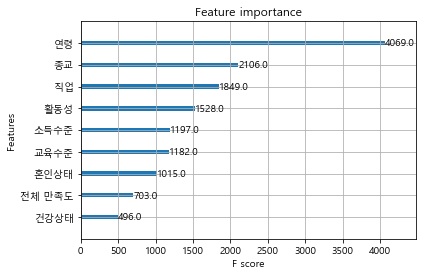

In [67]:
from xgboost import plot_importance
import matplotlib
matplotlib.rcParams['font.family'] ='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] =False

plot_importance(xgb)

#### 하이퍼파라미터 튜닝

In [33]:
# !pip install bayesian-optimization

In [68]:
from bayes_opt import BayesianOptimization

pbounds = {'max_depth': (3, 7),
                'learning_rate': (0.1, 0.3),
                'n_estimators': (500, 1000),
                'gamma': (0, 10),
                'min_child_weight': (0, 1),
                'subsample': (0.5, 1)
          }

In [69]:
def XGB_cv(max_depth,learning_rate, n_estimators, gamma
             ,min_child_weight, subsample):
    
    model = XGBClassifier(max_depth=int(max_depth),
                            learning_rate=learning_rate,
                            n_estimators=int(n_estimators),
                            gamma=gamma,
                            min_child_weight=min_child_weight,
                            subsample=subsample,
                            ramdom_state=2022)
    
    X_train, X_test, y_train, y_test = train_test_split(
        df.iloc[:,:-1], df.iloc[:,-1], test_size=0.2, random_state=2022)
    
    model.fit(X_train, y_train, eval_metric='merror')
    score = model.score(X_test, y_test)
    
    return score

In [70]:
# Bayesian optimization 객체 생성

bo=BayesianOptimization(f=XGB_cv, pbounds=pbounds)

In [71]:
# 메소드를 이용해 최대화 과정 수행
# init_points :  초기 Random Search 갯수
# n_iter : 반복 횟수 (몇개의 입력값-함숫값 점들을 확인할지! 많을 수록 정확한 값을 얻을 수 있다.)
# acq : Acquisition Function들 중 Expected Improvement(EI) 를 사용
# xi : exploration 강도 (기본값은 0.0)

bo.maximize(init_points=2, n_iter=10, acq='ei', xi=0.01)
print(bo.max)

|   iter    |  target   |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------
[16:31:17] WARNING: ..\src\learner.cc:576: 
Parameters: { "ramdom_state" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


|  1        |  0.5609   |  0.4977   |  0.1319   |  6.988    |  0.07938  |  953.1    |  0.8294   |
[16:31:25] WARNING: ..\src\learner.cc:576: 
Parameters: { "ramdom_state" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you fin

In [72]:
xgb_tune =XGBClassifier(gamma = 3.250759007130376,
                        learning_rate = 0.16582652863656727,
                        max_depth = 5, 
                        min_child_weight = 0.6076100653159745,
                        n_estimators = 808, 
                        subsample = 0.7850592982695779)
xgb_tune.fit(X_train, y_train, early_stopping_rounds = 100, eval_metric='merror', eval_set=evals , verbose=True)
xgb_tune.score(X_test, y_test)

[0]	validation_0-merror:0.36754
[1]	validation_0-merror:0.36277
[2]	validation_0-merror:0.36277
[3]	validation_0-merror:0.36277
[4]	validation_0-merror:0.36277
[5]	validation_0-merror:0.36038
[6]	validation_0-merror:0.36038
[7]	validation_0-merror:0.36038
[8]	validation_0-merror:0.35561
[9]	validation_0-merror:0.35800
[10]	validation_0-merror:0.35800
[11]	validation_0-merror:0.35800
[12]	validation_0-merror:0.35800
[13]	validation_0-merror:0.36277
[14]	validation_0-merror:0.36277
[15]	validation_0-merror:0.36277
[16]	validation_0-merror:0.36038
[17]	validation_0-merror:0.36038
[18]	validation_0-merror:0.36277
[19]	validation_0-merror:0.36038
[20]	validation_0-merror:0.36038
[21]	validation_0-merror:0.35800
[22]	validation_0-merror:0.35800
[23]	validation_0-merror:0.35800
[24]	validation_0-merror:0.36516
[25]	validation_0-merror:0.36277
[26]	validation_0-merror:0.36277
[27]	validation_0-merror:0.36038
[28]	validation_0-merror:0.36038
[29]	validation_0-merror:0.36038
[30]	validation_0-me

0.649164677804296

In [79]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, xgb.predict(X_test))

0.6348448687350835

In [80]:
accuracy_score(y_test, xgb_tune.predict(X_test))

0.649164677804296

#### 에러 측정

In [86]:
predict_test_tune = xgb_tune.predict(X_test)

In [87]:
mse = mean_squared_error(y_test, predict_test)
mse_tune = mean_squared_error(y_test, predict_test_tune)

r2 = r2_score(y_test, predict_test)
r2_tune = r2_score(y_test, predict_test_tune)

In [88]:
print('Mean squared error: ', mse ,'/', mse_tune)
print('R2 score: ', r2 ,'/', r2_tune)

Mean squared error:  2.4749403341288785 / 2.4821002386634845
R2 score:  -0.3432061134777207 / -0.34709195565750206


In [89]:
# 전처리한 데이터 csv로 저장
df.to_csv("./processed_df.csv", index=False)